# Modelos de crescimento e produção baseado em árvore individual

## Objetivo

Propor um modelo probabilistico de crescimento e produção baseado em árvore individual para a TRC. Os dados que serão usados para ajustes dos modelos probabilísticos foram fornecidos pela empresa, sendo portanto os resultados da modelagem dependentes desta base de dados.

# Módulos Python

In [1]:
import pandas as pd
import math as m
import numpy as np

from scipy.stats import gamma 
from scipy.stats import binom 
from scipy.stats import norm
from statsmodels.formula.api import glm
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution

import seaborn as sns
import matplotlib.pyplot as plt

# import datetime as dt

# Preparação da base de dados

- Importar bases de inventário fornecidas em dois pacotes. 
- *Antes de 2017*: parcelas eram circulares. 
- *Após 2018*: parcelas passaram a ser retangulares e aumentaram em locais onde o segundo desbaste foi realizado.

In [2]:
trc2017 = pd.read_csv('./dados/antes2017.csv', encoding='latin-1')
trc2018 = pd.read_csv('./dados/pos2018.csv', encoding='latin-1')
anoDesbaste = pd.read_csv('./dados/desbaste.csv', encoding='latin-1')

- Padronizar nomes das colunas do trc2018 com o trc2017.

In [3]:
trc2018.columns = ['ESTADO', 'CODPROJETO', 'ANO', 'CLONESEMENTE', 'CODTALHAO', 'ANOREF',
       'ANOREF.1', 'CHATALHAO', 'NUMPARCELA', 'CHAVE', 'AREA', 'AREA.1', 'I1',
       'I2', 'FILA', 'FILA.1', 'NUMARVORE', 'NUMARVORE.1',
       'DAP1', 'DAP2', 'ALT1', 'ALT2', 'ALTEST1', 'ALTEST2', 'VCCI', 'VCCI2',
       'S', 'CLONESEMENTE.1', 'índice']

In [4]:
trc2018.drop(['FILA', 'FILA.1'], axis=1, inplace=True)

- Confere tamanho dos arquivos.

In [5]:
print(trc2017.shape, trc2018.shape)

(3089, 27) (586, 27)


- Unifica as bases pré 2017 e pós 2018.

In [6]:
trc = pd.concat([trc2017, trc2018])
# trc.set_index(['CODPROJETO','CODTALHAO'], inplace=True)
trc.shape
# trc.dtypes

(3675, 27)

- Criar variáveis para explorar os dados e relações: 
    - sítio categórica
    - tempo entre inventários
    - incremento
    - incremento anual
    - incremento percentual
    - binário crescer

In [7]:
trc['sitio'] = pd.cut(trc['S'], 3, labels=["baixo", "medio", "alto"])
trc['idadeInteira'] = trc['I1'] // 1
trc['IntervaloMed'] = trc['I2'] - trc['I1']
trc['incremento'] = trc['DAP2'] - trc['DAP1']
trc['incAnual'] = trc['incremento'] / trc['IntervaloMed']
trc['incAnualPerc'] = trc['incAnual'] / trc['DAP1']
trc['binarioCrescer'] = trc['incAnual'].apply(lambda x: 0 if x == 0 else 1)
trc.head()

,ESTADO,CODPROJETO,ANO,CLONESEMENTE,CODTALHAO,ANOREF,ANOREF.1,CHATALHAO,NUMPARCELA,CHAVE,...,S,CLONESEMENTE.1,índice,sitio,idadeInteira,IntervaloMed,incremento,incAnual,incAnualPerc,binarioCrescer
0,MT,MTV,2005,SEED,001A,2007,2008,599,4494,599-4494,...,19.99,SEED,1,baixo,1.0,1.0,4.9,4.900000,1.689655,1
1,MT,MTV,2005,SEED,001A,2008,2009,599,4494,599-4494,...,19.99,SEED,1,baixo,2.0,1.0,1.6,1.600000,0.205128,1
2,MT,MTV,2005,SEED,001A,2009,2010,599,4494,599-4494,...,19.99,SEED,1,baixo,3.0,1.0,3.8,3.800000,0.404255,1
3,MT,MTV,2005,SEED,001A,2013,2014,599,4494,599-4494,...,19.99,SEED,2,baixo,7.0,1.1,1.1,1.000000,0.053476,1
4,MT,MTV,2005,SEED,001A,2014,2015,599,4494,599-4494,...,19.99,SEED,2,baixo,8.0,0.7,1.2,1.714286,0.086580,1


- Mescla informação de desbaste com dados de inventário

In [8]:
trc2 = trc.merge(anoDesbaste, how='left', 
                 left_on=['CODPROJETO','CODTALHAO','ANOREF'], 
                 right_on=['CODPROJETO','CODTALHAO','DEBASTE'])
# trc2.head()
trc2.shape

(3675, 38)

- Remove árvores com incremento anual diamétrica em percentagem exagerados (outliers)

In [9]:
trc2 = trc2[trc2.incAnualPerc < 0.9]
trc2.shape

(3491, 38)

- Calcula centro de classe da primeira medição

In [10]:
intervaloClasse = 10.0
diametroMin = 10.0

classeMax = ((max(trc2['DAP1']) // intervaloClasse) + 1) * intervaloClasse
intervalos = list(np.arange(diametroMin, classeMax, intervaloClasse))
intervalos = [(x - 0.001) for x in intervalos]
centros = [round(x + intervaloClasse/2.0, 0) for x in intervalos[:-1]]
trc2 = trc2[trc2['DAP1'] >= diametroMin]
trc2['CC1'] = pd.cut(trc2['DAP1'], bins=intervalos, labels=centros)
# trc2.head()

- Base final que segiu para o restante das análises.

In [11]:
trc2.head()
# trc2['CC1'].unique()

,ESTADO,CODPROJETO,ANO,CLONESEMENTE,CODTALHAO,ANOREF,ANOREF.1,CHATALHAO,NUMPARCELA,CHAVE,...,IntervaloMed,incremento,incAnual,incAnualPerc,binarioCrescer,DEBASTE,DESBASTESEQ,REMANESCENTE,TIPODESBASTE,CC1
3,MT,MTV,2005,SEED,001A,2013,2014,599,4494,599-4494,...,1.1,1.1,1.000000,0.053476,1,2013.0,1.0,NaN,NaN,15.0
4,MT,MTV,2005,SEED,001A,2014,2015,599,4494,599-4494,...,0.7,1.2,1.714286,0.086580,1,2014.0,1.0,NaN,NaN,15.0
5,MT,MTV,2005,SEED,001A,2015,2016,599,4494,599-4494,...,1.0,0.6,0.600000,0.028571,1,2015.0,2.0,333.0,Sistemático,25.0
6,MT,MTV,2005,SEED,001A,2016,2017,599,4494,599-4494,...,1.2,1.0,0.833333,0.038580,1,2016.0,2.0,NaN,NaN,25.0
10,MT,MTV,2005,SEED,001A,2010,2011,599,4494,599-4494,...,1.1,2.6,2.363636,0.207337,1,2010.0,1.0,556.0,NaN,15.0


# Modelagem crescimento I1 e I2

## Modelando a altura

- Apresenta gráfico de H2 = f(H1) evidenciando o sítio

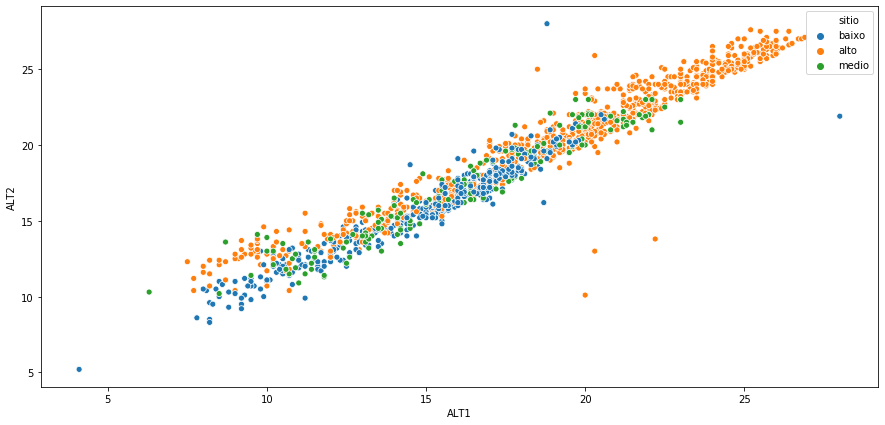

In [12]:
plt.figure(figsize=(15,7))
ax = sns.scatterplot(x="ALT1", y="ALT2", hue="sitio", data=trc2[(trc2['ALT1'] > 0) & (trc2['ALT2'] > 0)])

- Ajusta modelo linear h2 = f(h1) para todos os dados

In [13]:
alt1 = trc2.loc[(trc2['ALT1'] > 0) & (trc2['ALT2'] > 0), 'ALT1'].values.reshape(-1, 1)
alt2 = trc2.loc[(trc2['ALT1'] > 0) & (trc2['ALT2'] > 0), 'ALT2'].values.reshape(-1, 1)

projH = LinearRegression().fit(alt1, alt2)

print('b0:', projH.intercept_)
print('b1:', projH.coef_)
r_sq = projH.score(alt1, alt2)
print('R²', r_sq)

b0: [2.40297443]
b1: [[0.92654313]]
R² 0.942522450112096


- Plotar modelo linear h2 = f(h1)

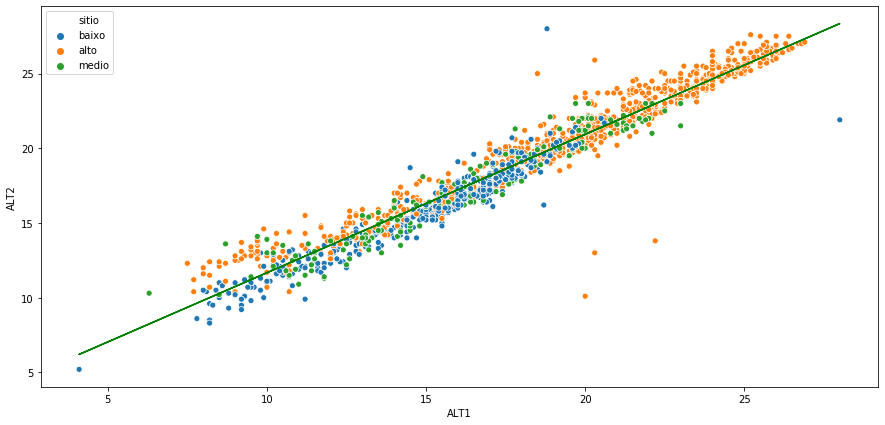

In [14]:
plt.figure(figsize=(15,7))
ax = sns.scatterplot(x="ALT1", y="ALT2", hue="sitio", data=trc2[(trc2['ALT1'] > 0) & (trc2['ALT2'] > 0)])
h_pred = projH.predict(alt1)
plt.plot(alt1, h_pred, color='green')

- Apresenta gráfico de resíduos do modelo linear para altura

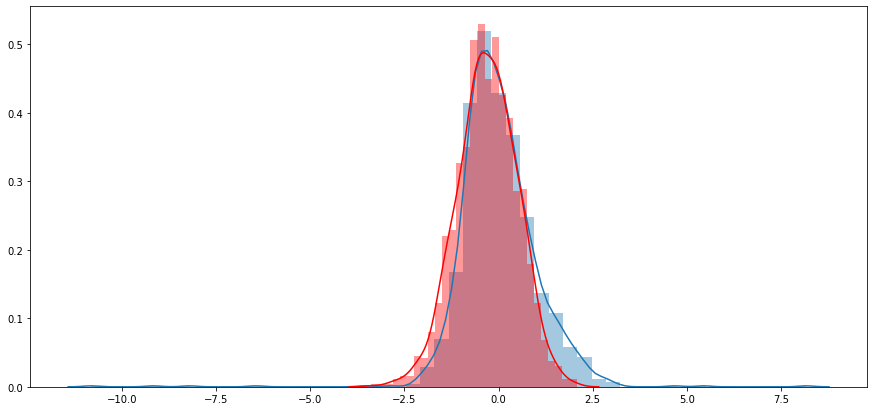

In [15]:
resH = alt2 - h_pred
plt.figure(figsize=(15,7))
ax = sns.distplot(resH)
erro = np.random.normal(-0.3, 0.78, 1397)
sns.distplot(erro, color='red')

## Modelando o diâmetro

- Apresenta gráfico de DAP2 = f(DAP1) considerando diferentes informações da base de dados

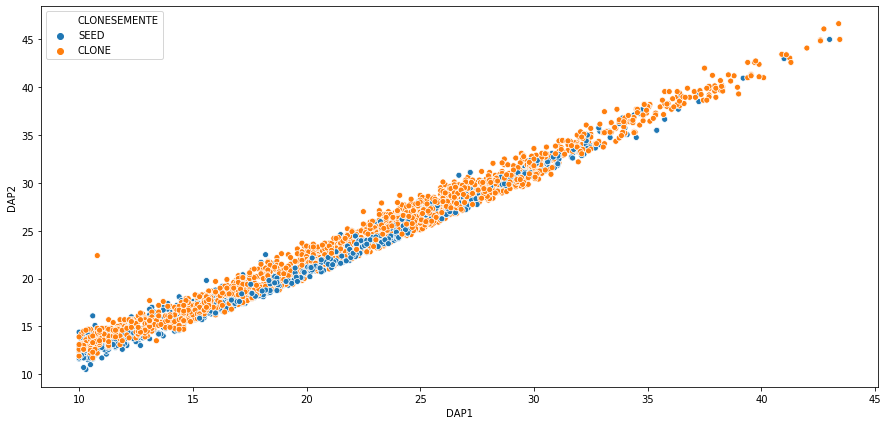

In [16]:
plt.figure(figsize=(15,7))
ax = sns.scatterplot(x="DAP1", y="DAP2", hue="CLONESEMENTE", data=trc2)

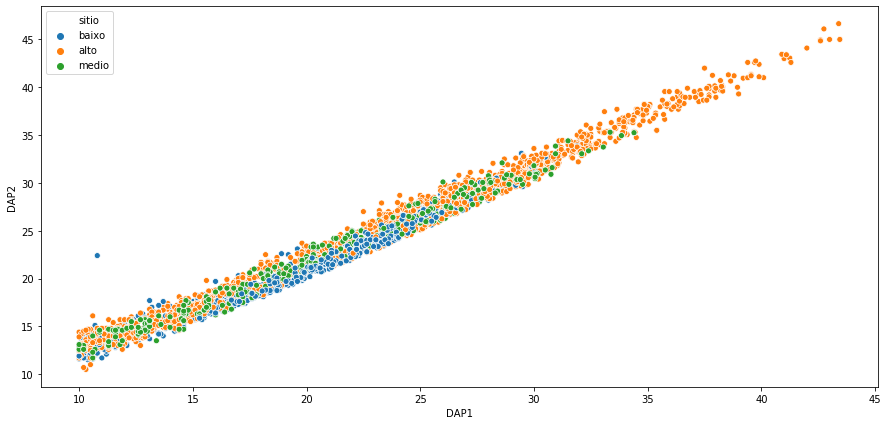

In [17]:
plt.figure(figsize=(15,7))
ax = sns.scatterplot(x="DAP1", y="DAP2", hue="sitio", data=trc2)

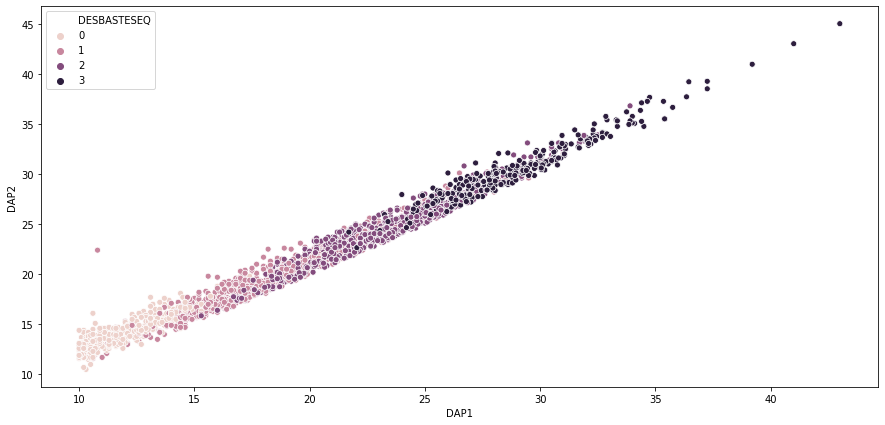

In [18]:
plt.figure(figsize=(15,7))
ax = sns.scatterplot(x="DAP1", y="DAP2", hue="DESBASTESEQ", data=trc2)

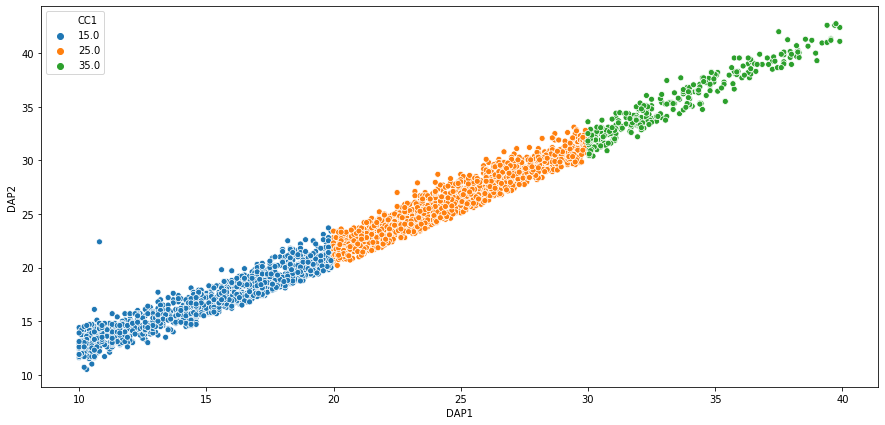

In [19]:
plt.figure(figsize=(15,7))
ax = sns.scatterplot(x="DAP1", y="DAP2", hue="CC1", data=trc2)

- Ajusta modelo linear dap2 = f(dap1) para todos os dados

In [20]:
dap1 = trc2['DAP1'].values.reshape(-1, 1)
dap2 = trc2['DAP2'].values.reshape(-1, 1)

projD = LinearRegression().fit(dap1, dap2)

print('intercept:', projD.intercept_)
print('slope:', projD.coef_)
r_sq = projD.score(dap1, dap2)
print('R²:', r_sq)

intercept: [1.7933069]
slope: [[0.99094079]]
R²: 0.9795037785906249


- Plotar modelo linear dap2 = f(dap1)

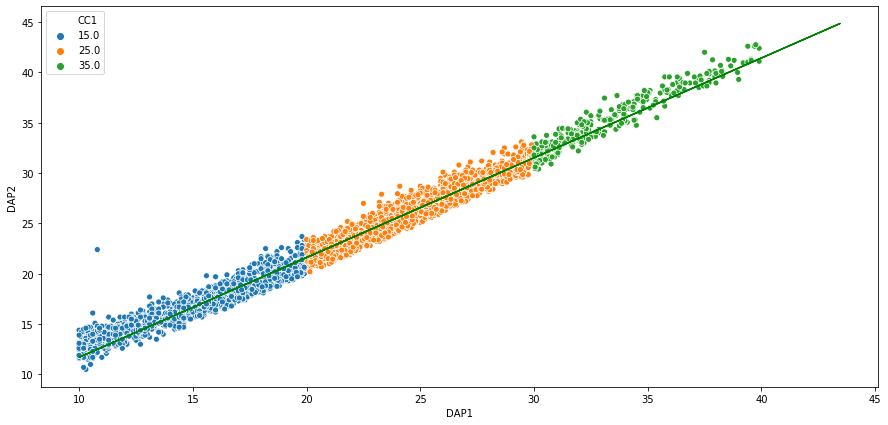

In [21]:
plt.figure(figsize=(15,7))
ax = sns.scatterplot(x="DAP1", y="DAP2", hue="CC1", data=trc2)
d_pred = projD.predict(dap1)
plt.plot(dap1, d_pred, color='green')

- Apresenta gráfico de resíduos do modelo linear para diâmetro

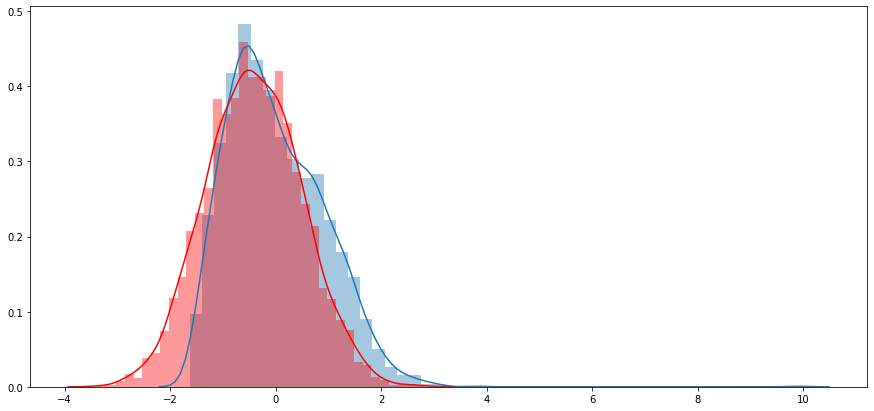

In [22]:
resD = dap2 - d_pred
plt.figure(figsize=(15,7))
ax = sns.distplot(resD)
erro = np.random.normal(-0.4, 0.9, 3083)
sns.distplot(erro, color='red')

# Modelagem bayesiana do crescimento

- Calcula probabilidade de crescer

In [23]:
probCrescer = trc2[trc2['binarioCrescer'] == 1].shape[0] / trc2.shape[0]
print(probCrescer)

0.9967564060979566


- Avalia a distrbuição dos incrementos percentuais observados

Desbaste | Semente + Sitio alto

In [24]:
CsSaD0 = trc2.loc[(trc2['CLONESEMENTE'] == 'SEED') & (trc2['sitio'] == 'alto') & (trc2['DESBASTESEQ'] == 0), 'incAnualPerc']
CsSaD1 = trc2.loc[(trc2['CLONESEMENTE'] == 'SEED') & (trc2['sitio'] == 'alto') & (trc2['DESBASTESEQ'] == 1), 'incAnualPerc']
CsSaD2 = trc2.loc[(trc2['CLONESEMENTE'] == 'SEED') & (trc2['sitio'] == 'alto') & (trc2['DESBASTESEQ'] == 2), 'incAnualPerc']
CsSaD3 = trc2.loc[(trc2['CLONESEMENTE'] == 'SEED') & (trc2['sitio'] == 'alto') & (trc2['DESBASTESEQ'] == 3), 'incAnualPerc']

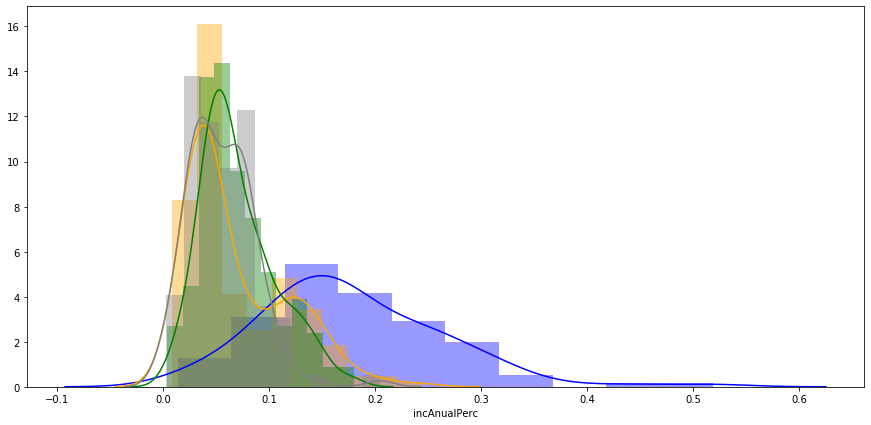

In [25]:
plt.figure(figsize=(15,7))
sns.distplot(CsSaD0, color='blue')
sns.distplot(CsSaD1, color='orange')
sns.distplot(CsSaD2, color='green')
sns.distplot(CsSaD3, color='gray')

Desbaste | Semente + Sitio médio e baixo

In [45]:
CsSbmD0 = trc2.loc[(trc2['CLONESEMENTE'] == 'SEED') & (trc2['sitio'] != 'alto') & (trc2['DESBASTESEQ'] == 0), 'incAnualPerc']
CsSbmD1 = trc2.loc[(trc2['CLONESEMENTE'] == 'SEED') & (trc2['sitio'] != 'alto') & (trc2['DESBASTESEQ'] == 1), 'incAnualPerc']
CsSbmD2 = trc2.loc[(trc2['CLONESEMENTE'] == 'SEED') & (trc2['sitio'] != 'alto') & (trc2['DESBASTESEQ'] == 2), 'incAnualPerc']
CsSbmD3 = trc2.loc[(trc2['CLONESEMENTE'] == 'SEED') & (trc2['sitio'] != 'alto') & (trc2['DESBASTESEQ'] == 3), 'incAnualPerc']

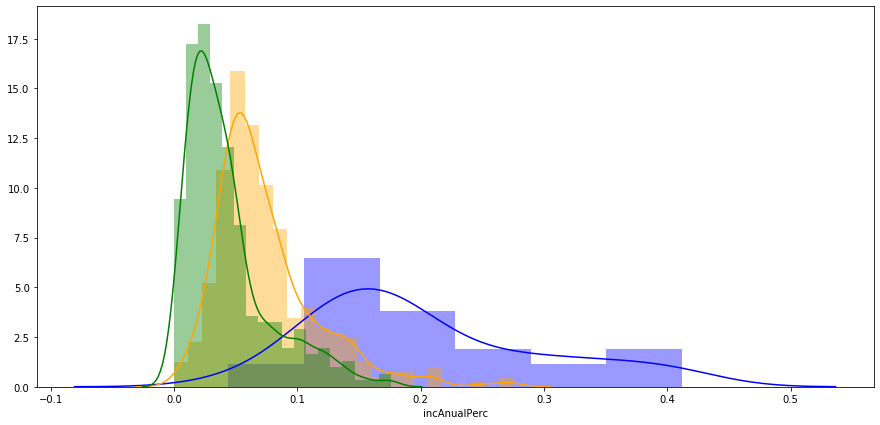

In [47]:
plt.figure(figsize=(15,7))
sns.distplot(CsSbmD0, color='blue')
sns.distplot(CsSbmD1, color='orange')
sns.distplot(CsSbmD2, color='green')

Desbaste | Clone + Sitio alto

In [48]:
CcSaD0 = trc2.loc[(trc2['CLONESEMENTE'] == 'CLONE') & (trc2['sitio'] == 'alto') & (trc2['DESBASTESEQ'] == 0), 'incAnualPerc']
CcSaD1 = trc2.loc[(trc2['CLONESEMENTE'] == 'CLONE') & (trc2['sitio'] == 'alto') & (trc2['DESBASTESEQ'] == 1), 'incAnualPerc']
CcSaD2 = trc2.loc[(trc2['CLONESEMENTE'] == 'CLONE') & (trc2['sitio'] == 'alto') & (trc2['DESBASTESEQ'] == 2), 'incAnualPerc']
CcSaD3 = trc2.loc[(trc2['CLONESEMENTE'] == 'CLONE') & (trc2['sitio'] == 'alto') & (trc2['DESBASTESEQ'] == 3), 'incAnualPerc']

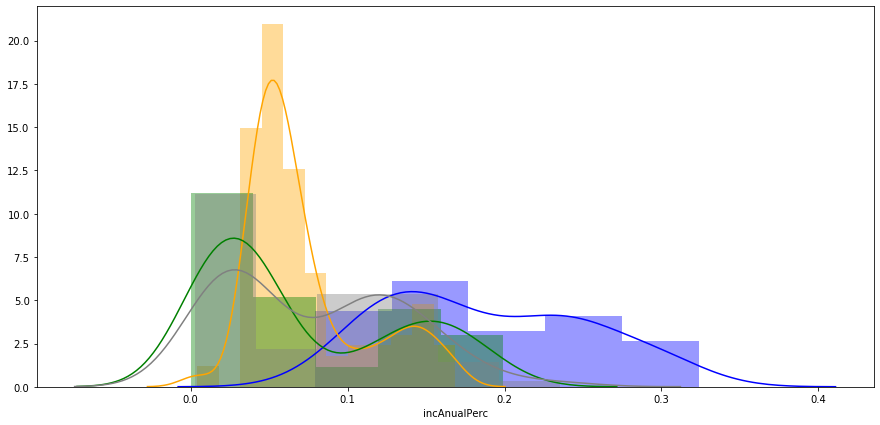

In [49]:
plt.figure(figsize=(15,7))
sns.distplot(CcSaD0, color='blue')
sns.distplot(CcSaD1, color='orange')
sns.distplot(CcSaD2, color='green')
sns.distplot(CcSaD3, color='gray')

Desbaste | Clone + Sitio médio e baixo

In [50]:
CcSbmD0 = trc2.loc[(trc2['CLONESEMENTE'] == 'CLONE') & (trc2['sitio'] != 'alto') & (trc2['DESBASTESEQ'] == 0), 'incAnualPerc']
CcSbmD1 = trc2.loc[(trc2['CLONESEMENTE'] == 'CLONE') & (trc2['sitio'] != 'alto') & (trc2['DESBASTESEQ'] == 1), 'incAnualPerc']
CcSbmD2 = trc2.loc[(trc2['CLONESEMENTE'] == 'CLONE') & (trc2['sitio'] != 'alto') & (trc2['DESBASTESEQ'] == 2), 'incAnualPerc']
CcSbmD3 = trc2.loc[(trc2['CLONESEMENTE'] == 'CLONE') & (trc2['sitio'] != 'alto') & (trc2['DESBASTESEQ'] == 3), 'incAnualPerc']

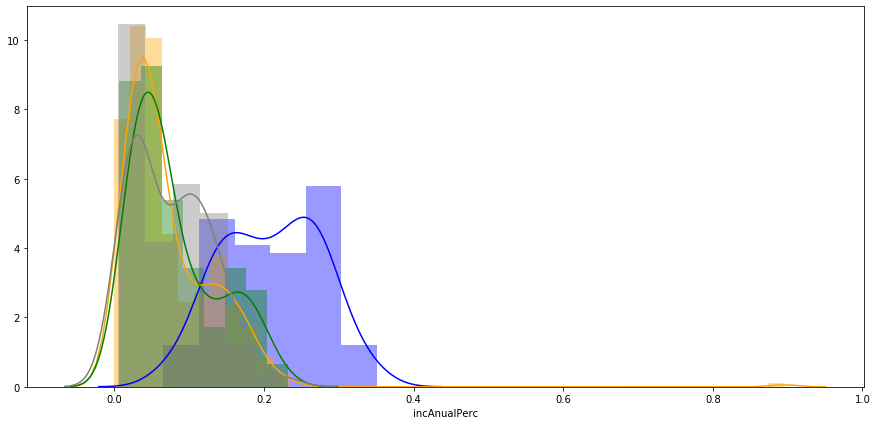

In [51]:
plt.figure(figsize=(15,7))
sns.distplot(CcSbmD0, color='blue')
sns.distplot(CcSbmD1, color='orange')
sns.distplot(CcSbmD2, color='green')
sns.distplot(CcSbmD3, color='gray')

- Extrair parâmetros da distribuição

In [29]:
parameters = pd.DataFrame({'MatGen': ['SEED', 'SEED', 'SEED', 'SEED',
                                    'SEED', 'SEED', 'SEED', 'SEED',
                                    'SEED', 'SEED', 'SEED', 'SEED',
                                    'CLONE', 'CLONE', 'CLONE', 'CLONE',
                                    'CLONE', 'CLONE', 'CLONE', 'CLONE',
                                    'CLONE', 'CLONE', 'CLONE', 'CLONE'],
                           'Sitio': ['baixo', 'baixo', 'baixo', 'baixo',
                                     'medio', 'medio', 'medio', 'medio',
                                     'alto', 'alto', 'alto', 'alto',
                                     'baixo', 'baixo', 'baixo', 'baixo',
                                     'medio', 'medio', 'medio', 'medio',
                                     'alto', 'alto', 'alto', 'alto'],
                           'Desbaste': [0, 1, 2, 3,
                                        0, 1, 2, 3,
                                        0, 1, 2, 3,
                                        0, 1, 2, 3,
                                        0, 1, 2, 3,
                                        0, 1, 2, 3],
                           'Param1': [0., 0, 0, 0,
                                        0, 0, 0, 0,
                                        0, 0, 0, 0,
                                        0, 0, 0, 0,
                                        0, 0, 0, 0,
                                        0, 0, 0, 0],
                           'Param2': [0., 0, 0, 0,
                                        0, 0, 0, 0,
                                        0, 0, 0, 0,
                                        0, 0, 0, 0,
                                        0, 0, 0, 0,
                                        0, 0, 0, 0],
                           'Param3': [0., 0, 0, 0,
                                        0, 0, 0, 0,
                                        0, 0, 0, 0,
                                        0, 0, 0, 0,
                                        0, 0, 0, 0,
                                        0, 0, 0, 0]})

In [30]:
param = gamma.fit(CcSaD0)
parameters.loc[(parameters['MatGen'] == 'CLONE') & (parameters['Sitio'] == 'alto') & (parameters['Desbaste'] == 0), 'Param1'] = param[0]
parameters.loc[(parameters['MatGen'] == 'CLONE') & (parameters['Sitio'] == 'alto') & (parameters['Desbaste'] == 0), 'Param2'] = param[1]
parameters.loc[(parameters['MatGen'] == 'CLONE') & (parameters['Sitio'] == 'alto') & (parameters['Desbaste'] == 0), 'Param3'] = param[2]

param = gamma.fit(CcSaD1)
parameters.loc[(parameters['MatGen'] == 'CLONE') & (parameters['Sitio'] == 'alto') & (parameters['Desbaste'] == 1), 'Param1'] = param[0]
parameters.loc[(parameters['MatGen'] == 'CLONE') & (parameters['Sitio'] == 'alto') & (parameters['Desbaste'] == 1), 'Param2'] = param[1]
parameters.loc[(parameters['MatGen'] == 'CLONE') & (parameters['Sitio'] == 'alto') & (parameters['Desbaste'] == 1), 'Param3'] = param[2]

param = gamma.fit(CcSaD2)
parameters.loc[(parameters['MatGen'] == 'CLONE') & (parameters['Sitio'] == 'alto') & (parameters['Desbaste'] == 2), 'Param1'] = param[0]
parameters.loc[(parameters['MatGen'] == 'CLONE') & (parameters['Sitio'] == 'alto') & (parameters['Desbaste'] == 2), 'Param2'] = param[1]
parameters.loc[(parameters['MatGen'] == 'CLONE') & (parameters['Sitio'] == 'alto') & (parameters['Desbaste'] == 2), 'Param3'] = param[2]

param = gamma.fit(CcSbmD3)
parameters.loc[(parameters['MatGen'] == 'CLONE') & (parameters['Sitio'] == 'alto') & (parameters['Desbaste'] == 3), 'Param1'] = param[0]
parameters.loc[(parameters['MatGen'] == 'CLONE') & (parameters['Sitio'] == 'alto') & (parameters['Desbaste'] == 3), 'Param2'] = param[1]
parameters.loc[(parameters['MatGen'] == 'CLONE') & (parameters['Sitio'] == 'alto') & (parameters['Desbaste'] == 3), 'Param3'] = param[2]

param = gamma.fit(CcSbmD0)
parameters.loc[(parameters['MatGen'] == 'CLONE') & (parameters['Sitio'] == 'baixo') & (parameters['Desbaste'] == 0), 'Param1'] = param[0]
parameters.loc[(parameters['MatGen'] == 'CLONE') & (parameters['Sitio'] == 'baixo') & (parameters['Desbaste'] == 0), 'Param2'] = param[1]
parameters.loc[(parameters['MatGen'] == 'CLONE') & (parameters['Sitio'] == 'baixo') & (parameters['Desbaste'] == 0), 'Param3'] = param[2]
parameters.loc[(parameters['MatGen'] == 'CLONE') & (parameters['Sitio'] == 'medio') & (parameters['Desbaste'] == 0), 'Param1'] = param[0]
parameters.loc[(parameters['MatGen'] == 'CLONE') & (parameters['Sitio'] == 'medio') & (parameters['Desbaste'] == 0), 'Param2'] = param[1]
parameters.loc[(parameters['MatGen'] == 'CLONE') & (parameters['Sitio'] == 'medio') & (parameters['Desbaste'] == 0), 'Param3'] = param[2]

param = gamma.fit(CcSbmD1)
parameters.loc[(parameters['MatGen'] == 'CLONE') & (parameters['Sitio'] == 'baixo') & (parameters['Desbaste'] == 1), 'Param1'] = param[0]
parameters.loc[(parameters['MatGen'] == 'CLONE') & (parameters['Sitio'] == 'baixo') & (parameters['Desbaste'] == 1), 'Param2'] = param[1]
parameters.loc[(parameters['MatGen'] == 'CLONE') & (parameters['Sitio'] == 'baixo') & (parameters['Desbaste'] == 1), 'Param3'] = param[2]
parameters.loc[(parameters['MatGen'] == 'CLONE') & (parameters['Sitio'] == 'medio') & (parameters['Desbaste'] == 1), 'Param1'] = param[0]
parameters.loc[(parameters['MatGen'] == 'CLONE') & (parameters['Sitio'] == 'medio') & (parameters['Desbaste'] == 1), 'Param2'] = param[1]
parameters.loc[(parameters['MatGen'] == 'CLONE') & (parameters['Sitio'] == 'medio') & (parameters['Desbaste'] == 1), 'Param3'] = param[2]

param = gamma.fit(CcSbmD2)
parameters.loc[(parameters['MatGen'] == 'CLONE') & (parameters['Sitio'] == 'baixo') & (parameters['Desbaste'] == 2), 'Param1'] = param[0]
parameters.loc[(parameters['MatGen'] == 'CLONE') & (parameters['Sitio'] == 'baixo') & (parameters['Desbaste'] == 2), 'Param2'] = param[1]
parameters.loc[(parameters['MatGen'] == 'CLONE') & (parameters['Sitio'] == 'baixo') & (parameters['Desbaste'] == 2), 'Param3'] = param[2]
parameters.loc[(parameters['MatGen'] == 'CLONE') & (parameters['Sitio'] == 'medio') & (parameters['Desbaste'] == 2), 'Param1'] = param[0]
parameters.loc[(parameters['MatGen'] == 'CLONE') & (parameters['Sitio'] == 'medio') & (parameters['Desbaste'] == 2), 'Param2'] = param[1]
parameters.loc[(parameters['MatGen'] == 'CLONE') & (parameters['Sitio'] == 'medio') & (parameters['Desbaste'] == 2), 'Param3'] = param[2]

param = gamma.fit(CcSbmD3)
parameters.loc[(parameters['MatGen'] == 'CLONE') & (parameters['Sitio'] == 'baixo') & (parameters['Desbaste'] == 3), 'Param1'] = param[0]
parameters.loc[(parameters['MatGen'] == 'CLONE') & (parameters['Sitio'] == 'baixo') & (parameters['Desbaste'] == 3), 'Param2'] = param[1]
parameters.loc[(parameters['MatGen'] == 'CLONE') & (parameters['Sitio'] == 'baixo') & (parameters['Desbaste'] == 3), 'Param3'] = param[2]
parameters.loc[(parameters['MatGen'] == 'CLONE') & (parameters['Sitio'] == 'medio') & (parameters['Desbaste'] == 3), 'Param1'] = param[0]
parameters.loc[(parameters['MatGen'] == 'CLONE') & (parameters['Sitio'] == 'medio') & (parameters['Desbaste'] == 3), 'Param2'] = param[1]
parameters.loc[(parameters['MatGen'] == 'CLONE') & (parameters['Sitio'] == 'medio') & (parameters['Desbaste'] == 3), 'Param3'] = param[2]

param = gamma.fit(CsSaD0)
parameters.loc[(parameters['MatGen'] == 'SEED') & (parameters['Sitio'] == 'alto') & (parameters['Desbaste'] == 0), 'Param1'] = param[0]
parameters.loc[(parameters['MatGen'] == 'SEED') & (parameters['Sitio'] == 'alto') & (parameters['Desbaste'] == 0), 'Param2'] = param[1]
parameters.loc[(parameters['MatGen'] == 'SEED') & (parameters['Sitio'] == 'alto') & (parameters['Desbaste'] == 0), 'Param3'] = param[2]

param = gamma.fit(CsSaD1)
parameters.loc[(parameters['MatGen'] == 'SEED') & (parameters['Sitio'] == 'alto') & (parameters['Desbaste'] == 1), 'Param1'] = param[0]
parameters.loc[(parameters['MatGen'] == 'SEED') & (parameters['Sitio'] == 'alto') & (parameters['Desbaste'] == 1), 'Param2'] = param[1]
parameters.loc[(parameters['MatGen'] == 'SEED') & (parameters['Sitio'] == 'alto') & (parameters['Desbaste'] == 1), 'Param3'] = param[2]

param = gamma.fit(CsSaD2)
parameters.loc[(parameters['MatGen'] == 'SEED') & (parameters['Sitio'] == 'alto') & (parameters['Desbaste'] == 2), 'Param1'] = param[0]
parameters.loc[(parameters['MatGen'] == 'SEED') & (parameters['Sitio'] == 'alto') & (parameters['Desbaste'] == 2), 'Param2'] = param[1]
parameters.loc[(parameters['MatGen'] == 'SEED') & (parameters['Sitio'] == 'alto') & (parameters['Desbaste'] == 2), 'Param3'] = param[2]

param = gamma.fit(CsSaD3)
parameters.loc[(parameters['MatGen'] == 'SEED') & (parameters['Sitio'] == 'alto') & (parameters['Desbaste'] == 3), 'Param1'] = param[0]
parameters.loc[(parameters['MatGen'] == 'SEED') & (parameters['Sitio'] == 'alto') & (parameters['Desbaste'] == 3), 'Param2'] = param[1]
parameters.loc[(parameters['MatGen'] == 'SEED') & (parameters['Sitio'] == 'alto') & (parameters['Desbaste'] == 3), 'Param3'] = param[2]

param = gamma.fit(CsSbmD0)
parameters.loc[(parameters['MatGen'] == 'SEED') & (parameters['Sitio'] == 'baixo') & (parameters['Desbaste'] == 0), 'Param1'] = param[0]
parameters.loc[(parameters['MatGen'] == 'SEED') & (parameters['Sitio'] == 'baixo') & (parameters['Desbaste'] == 0), 'Param2'] = param[1]
parameters.loc[(parameters['MatGen'] == 'SEED') & (parameters['Sitio'] == 'baixo') & (parameters['Desbaste'] == 0), 'Param3'] = param[2]
parameters.loc[(parameters['MatGen'] == 'SEED') & (parameters['Sitio'] == 'medio') & (parameters['Desbaste'] == 0), 'Param1'] = param[0]
parameters.loc[(parameters['MatGen'] == 'SEED') & (parameters['Sitio'] == 'medio') & (parameters['Desbaste'] == 0), 'Param2'] = param[1]
parameters.loc[(parameters['MatGen'] == 'SEED') & (parameters['Sitio'] == 'medio') & (parameters['Desbaste'] == 0), 'Param3'] = param[2]

param = gamma.fit(CsSbmD1)
parameters.loc[(parameters['MatGen'] == 'SEED') & (parameters['Sitio'] == 'baixo') & (parameters['Desbaste'] == 1), 'Param1'] = param[0]
parameters.loc[(parameters['MatGen'] == 'SEED') & (parameters['Sitio'] == 'baixo') & (parameters['Desbaste'] == 1), 'Param2'] = param[1]
parameters.loc[(parameters['MatGen'] == 'SEED') & (parameters['Sitio'] == 'baixo') & (parameters['Desbaste'] == 1), 'Param3'] = param[2]
parameters.loc[(parameters['MatGen'] == 'SEED') & (parameters['Sitio'] == 'medio') & (parameters['Desbaste'] == 1), 'Param1'] = param[0]
parameters.loc[(parameters['MatGen'] == 'SEED') & (parameters['Sitio'] == 'medio') & (parameters['Desbaste'] == 1), 'Param2'] = param[1]
parameters.loc[(parameters['MatGen'] == 'SEED') & (parameters['Sitio'] == 'medio') & (parameters['Desbaste'] == 1), 'Param3'] = param[2]

param = gamma.fit(CsSbmD2)
parameters.loc[(parameters['MatGen'] == 'SEED') & (parameters['Sitio'] == 'baixo') & (parameters['Desbaste'] == 2), 'Param1'] = param[0]
parameters.loc[(parameters['MatGen'] == 'SEED') & (parameters['Sitio'] == 'baixo') & (parameters['Desbaste'] == 2), 'Param2'] = param[1]
parameters.loc[(parameters['MatGen'] == 'SEED') & (parameters['Sitio'] == 'baixo') & (parameters['Desbaste'] == 2), 'Param3'] = param[2]
parameters.loc[(parameters['MatGen'] == 'SEED') & (parameters['Sitio'] == 'medio') & (parameters['Desbaste'] == 2), 'Param1'] = param[0]
parameters.loc[(parameters['MatGen'] == 'SEED') & (parameters['Sitio'] == 'medio') & (parameters['Desbaste'] == 2), 'Param2'] = param[1]
parameters.loc[(parameters['MatGen'] == 'SEED') & (parameters['Sitio'] == 'medio') & (parameters['Desbaste'] == 2), 'Param3'] = param[2]


parameters.loc[(parameters['MatGen'] == 'SEED') & (parameters['Sitio'] == 'baixo') & (parameters['Desbaste'] == 3), 'Param1'] = param[0]
parameters.loc[(parameters['MatGen'] == 'SEED') & (parameters['Sitio'] == 'baixo') & (parameters['Desbaste'] == 3), 'Param2'] = param[1]
parameters.loc[(parameters['MatGen'] == 'SEED') & (parameters['Sitio'] == 'baixo') & (parameters['Desbaste'] == 3), 'Param3'] = param[2]
parameters.loc[(parameters['MatGen'] == 'SEED') & (parameters['Sitio'] == 'medio') & (parameters['Desbaste'] == 3), 'Param1'] = param[0]
parameters.loc[(parameters['MatGen'] == 'SEED') & (parameters['Sitio'] == 'medio') & (parameters['Desbaste'] == 3), 'Param2'] = param[1]
parameters.loc[(parameters['MatGen'] == 'SEED') & (parameters['Sitio'] == 'medio') & (parameters['Desbaste'] == 3), 'Param3'] = param[2]

In [31]:
parameters

,MatGen,Sitio,Desbaste,Param1,Param2,Param3
0,SEED,baixo,0,4.472533,9.976415e-03,0.043248
1,SEED,baixo,1,3.959602,-4.723001e-03,0.019948
2,SEED,baixo,2,1.716810,-3.521632e-04,0.025082
3,SEED,baixo,3,1.716810,-3.521632e-04,0.025082
4,SEED,medio,0,4.472533,9.976415e-03,0.043248
5,SEED,medio,1,3.959602,-4.723001e-03,0.019948
6,SEED,medio,2,1.716810,-3.521632e-04,0.025082
7,SEED,medio,3,1.716810,-3.521632e-04,0.025082
8,SEED,alto,0,8.679278,-7.057194e-02,0.028604
9,SEED,alto,1,1.697503,7.542955e-03,0.036419


# Aplicando os métodos

1. Resumo dos dados de inventário.

In [32]:
trc2.pivot_table(values='NUMARVORE', index=['CODPROJETO', 'CODTALHAO', 'NUMPARCELA'], columns='ANOREF', aggfunc='count')

ANOREF                           2007  2008  2009  2010  2011  2013  2014  \
CODPROJETO CODTALHAO NUMPARCELA                                             
MTV        001A      4494         NaN   NaN   8.0  19.0  20.0  71.0  74.0   
                     4503         NaN  10.0  25.0  16.0  16.0  67.0  69.0   
           010       4539         NaN  18.0  28.0  17.0  17.0  58.0  39.0   
                     4559         1.0  27.0  35.0  16.0  16.0  60.0  37.0   
           025B      4881         NaN   1.0  31.0  18.0  17.0  58.0  62.0   
           042A      5018         NaN  19.0  18.0  18.0  18.0  41.0  41.0   
                     5030         NaN   4.0  20.0  20.0  20.0  44.0  47.0   
           067A      4656         NaN  32.0  38.0  23.0  23.0  76.0  52.0   
                     4679         NaN  18.0  37.0  13.0  21.0  70.0  37.0   

ANOREF                           2015  2016  2018  2019  
CODPROJETO CODTALHAO NUMPARCELA                          
MTV        001A      4494        45.0  45.0  43.0  38.0  
                     4503        41.0  40.0  36.0  27.0  
           010       4539        40.0  39.0  34.0  29.0  
                     4559        36.0  37.0  28.0  25.0  
           025B      4881        62.0  62.0  27.0  26.0  
           042A      5018        40.0  42.0  31.0  31.0  
                     5030        47.0  47.0  37.0  37.0  
           067A      4656        53.0  45.0  37.0  35.0  
                     4679        38.0  37.0  33.0  32.0

2. Separa uma parcela para teste.

In [33]:
p_2014 = trc2.loc[(trc2['NUMPARCELA'] == 4539) & (trc2['ANOREF'] == 2014), ['DAP1', 'ALTEST1', 'CLONESEMENTE.1', 'sitio', 'DESBASTESEQ']]
p_2018 = trc2.loc[(trc2['NUMPARCELA'] == 4539) & (trc2['ANOREF'] == 2018), ['DAP1', 'ALTEST1', 'CLONESEMENTE.1', 'sitio', 'DESBASTESEQ']]
print(p_2014['DAP1'].mean(), p_2018['DAP1'].mean())
p_2014.sample(30)

22.56153846153846 28.777941176470588


,DAP1,ALTEST1,CLONESEMENTE.1,sitio,DESBASTESEQ
1025,20.7,19.1,SEED,alto,2.0
870,20.8,20.0,SEED,alto,2.0
959,26.1,21.9,SEED,alto,2.0
1012,22.3,19.4,SEED,alto,2.0
916,21.2,19.2,SEED,alto,2.0
1016,21.4,19.3,SEED,alto,2.0
1008,19.6,18.9,SEED,alto,2.0
884,21.8,19.3,SEED,alto,2.0
995,22.2,19.4,SEED,alto,2.0
824,24.4,19.5,SEED,alto,2.0


3. Verifica distribuição da altura e do diâmetro da parcela escolhida.

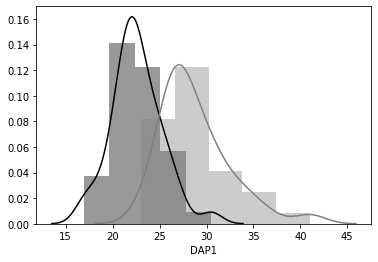

In [34]:
sns.distplot(p_2014['DAP1'], bins=5, color='black')
sns.distplot(p_2018['DAP1'], bins=5, color='gray')

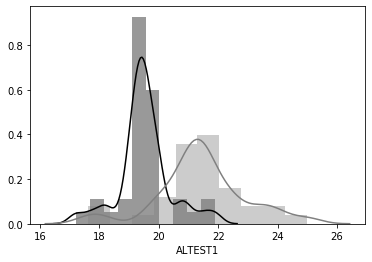

In [35]:
sns.distplot(p_2014['ALTEST1'], bins=10, color='black')
sns.distplot(p_2018['ALTEST1'], bins=10, color='gray')

## Projeção baseada em I1 e I2

OBS: Aqui observa-se a importância de se considerar o erro do modelo na projeção da produção. Na sequência abaixo, incluímos na estimativa baseada em árvores individuais o erro com média 0 e desvio padrão 0.8. Neste contexto, veja que a distribuição futura coincide com o observado. Como exemplo, projete considerando erro 0 e desvio 0 (ou seja, sem a presença do erro) e veja que a distribuição futura vai muito além dos dados observados. 

In [36]:
testeProj = p_2014.copy()

In [37]:
errMi = -0.3 #0
errSd = 0.8 #0
X = testeProj['ALTEST1'].values.reshape(-1, 1) 
Y_pred = projH.predict(X)
Y_erro = np.random.normal(errMi, errSd, testeProj.shape[0])
testeProj['ALTpred'] = Y_pred
testeProj['ALTerro'] = Y_erro
testeProj['ALT2015'] = testeProj['ALTpred'] + testeProj['ALTerro']
# testeProj.head()

X = testeProj['ALT2015'].values.reshape(-1, 1) 
Y_pred = projH.predict(X)
Y_erro = np.random.normal(errMi, errSd, testeProj.shape[0])
testeProj['ALTpred'] = Y_pred
testeProj['ALTerro'] = Y_erro
testeProj['ALT2016'] = testeProj['ALTpred'] + testeProj['ALTerro']
# testeProj.head()

X = testeProj['ALT2016'].values.reshape(-1, 1) 
Y_pred = projH.predict(X)
Y_erro = np.random.normal(errMi, errSd, testeProj.shape[0])
testeProj['ALTpred'] = Y_pred
testeProj['ALTerro'] = Y_erro
testeProj['ALT2017'] = testeProj['ALTpred'] + testeProj['ALTerro']
# testeProj.head()

X = testeProj['ALT2017'].values.reshape(-1, 1) 
Y_pred = projH.predict(X)
Y_erro = np.random.normal(errMi, errSd, testeProj.shape[0])
testeProj['ALTpred'] = Y_pred
testeProj['ALTerro'] = Y_erro
testeProj['ALT2018'] = testeProj['ALTpred'] + testeProj['ALTerro']
# testeProj.head()

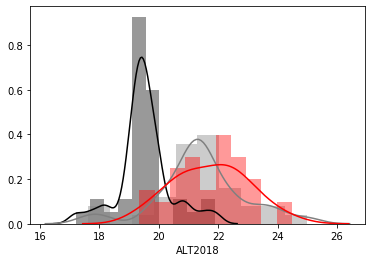

In [38]:
b = 10
sns.distplot(testeProj['ALTEST1'], bins=b, color='black')
sns.distplot(p_2018['ALTEST1'], bins=b, color='gray')
sns.distplot(testeProj['ALT2018'], bins=b, color='red')

In [39]:
errMi = -0.4
errSd = 0.9
X = testeProj['DAP1'].values.reshape(-1, 1) 
Y_pred = projD.predict(X)
Y_erro = np.random.normal(errMi, errSd, testeProj.shape[0])
testeProj['Dpred'] = Y_pred
testeProj['Derro'] = Y_erro
testeProj['DAP2015'] = testeProj['Dpred'] + testeProj['Derro']
# testeProj.head()

X = testeProj['DAP2015'].values.reshape(-1, 1) 
Y_pred = projD.predict(X)
Y_erro = np.random.normal(errMi, errSd, testeProj.shape[0])
testeProj['Dpred'] = Y_pred
testeProj['Derro'] = Y_erro
testeProj['DAP2016'] = testeProj['Dpred'] + testeProj['Derro']
# testeProj.head()

X = testeProj['DAP2016'].values.reshape(-1, 1) 
Y_pred = projD.predict(X)
Y_erro = np.random.normal(errMi, errSd, testeProj.shape[0])
testeProj['Dpred'] = Y_pred
testeProj['Derro'] = Y_erro
testeProj['DAP2017'] = testeProj['Dpred'] + testeProj['Derro']
# testeProj.head()

X = testeProj['DAP2017'].values.reshape(-1, 1) 
Y_pred = projD.predict(X)
Y_erro = np.random.normal(errMi, errSd, testeProj.shape[0])
testeProj['Dpred'] = Y_pred
testeProj['Derro'] = Y_erro
testeProj['DAP2018'] = testeProj['Dpred'] + testeProj['Derro']
# testeProj.head()

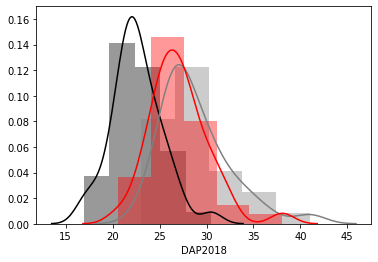

In [40]:
sns.distplot(testeProj['DAP1'], bins=5, color='black')
sns.distplot(p_2018['DAP1'], bins=5, color='gray')
sns.distplot(testeProj['DAP2018'], bins=5, color='red')

## Simulação baseada em crescimento e modelagem bayesiana

In [41]:
testeBayesian = p_2014.copy()
# testeBayesian.columns

In [42]:
def bayesianGrowth(x, paramMatrix = parameters):
  incPerc = gamma.rvs(paramMatrix.loc[(paramMatrix.MatGen == x[2]) & (paramMatrix.Sitio == x[3]) & (paramMatrix.Desbaste == x[4]), 'Param1'],
                      paramMatrix.loc[(paramMatrix.MatGen == x[2]) & (paramMatrix.Sitio == x[3]) & (paramMatrix.Desbaste == x[4]), 'Param2'],
                      paramMatrix.loc[(paramMatrix.MatGen == x[2]) & (paramMatrix.Sitio == x[3]) & (paramMatrix.Desbaste == x[4]), 'Param3'],
                      size=1)
  return x[0] + x[0] * incPerc[0]

# bayesianGrowth(testeBayesian.iloc[1])

In [43]:
testeBayesian['DAP1'] = testeBayesian.apply(bayesianGrowth, axis=1)
testeBayesian['DAP1'] = testeBayesian.apply(bayesianGrowth, axis=1)
testeBayesian['DAP1'] = testeBayesian.apply(bayesianGrowth, axis=1)
testeBayesian['DAP1'] = testeBayesian.apply(bayesianGrowth, axis=1)

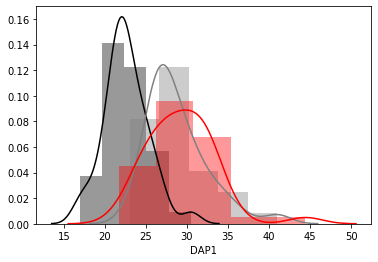

In [44]:
sns.distplot(p_2014['DAP1'], bins=5, color='black')
sns.distplot(p_2018['DAP1'], bins=5, color='gray')
sns.distplot(testeBayesian['DAP1'], bins=5, color='red')